In [1]:
import pandas as pd
import pickle
import seaborn as sns
from sklearn.cluster import KMeans #聚类模块
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_pickle('./output/df_performance-win-0924.pkl.zstd', compression='zstd')

In [3]:
df.webgl_time.count()

6406

In [4]:
a = df[~df.webgl_time.isna()].index.unique().tolist()
pickle.dump(a, open('./output/valid_ids.pkl', 'wb'))

In [5]:
df_webgl = df[~df.webgl_time.isna()]
df_webgl

,status,cpu_real,cpu_full,gpu_real,gpu_full,webgl_time,dropped_frame_duration,frames_count,mem_mean_browser,mem_mean_gpu_process,mem_mean_renderer,mem_mean_other,mem_detail
2,Ok,0.341193,0.385173,0.463825,0.659701,0.538061,9.132968,580.0,81.101562,870.302734,347.040820,271.567187,{'Service: audio.mojom.AudioService_6_3324': [...
11,Ok,0.344628,0.400140,0.695051,0.747496,0.501488,0.099996,595.0,78.840625,424.297461,271.012305,278.552344,"{'GPU Process_3_8556': [423.66015625, 423.9804..."
15,Ok,0.431406,0.476167,1.170316,1.260264,1.173689,0.066664,596.0,78.780273,490.459570,135.200781,215.819141,"{'Browser_2_488': [75.3359375, 77.49609375, 77..."
17,Ok,2.042734,2.167520,2.512404,2.604538,2.554558,0.099996,595.0,316.661914,1172.514648,1039.843164,283.295117,{'Service: audio.mojom.AudioService_6_8324': [...
20,Ok,0.544648,0.587801,0.486789,0.520200,0.379705,0.033332,599.0,78.170117,554.161328,178.023633,258.089844,"{'Renderer_1_4624': [176.78125, 177.3984375, 1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29217,Ok,0.976949,1.037434,0.437793,0.463700,0.400385,0.116662,594.0,80.671289,912.806836,634.661133,494.565625,"{'GPU Process_5_5144': [919.27734375, 919.1367..."
29219,Ok,0.477732,0.568039,0.478780,0.494425,0.217637,0.066664,597.0,78.314648,516.396680,140.059570,187.561914,"{'Renderer_1_8460': [136.65625, 138.76953125, ..."
29221,Ok,0.405280,0.463773,0.187927,0.196130,0.161195,0.233324,588.0,80.338867,468.408594,220.606641,265.718750,"{'Browser_2_3456': [76.94921875, 79.2109375, 7..."
29224,Ok,0.312799,0.359804,0.162175,0.169907,0.128084,0.099996,594.0,79.268750,409.140430,117.831250,252.937305,"{'Renderer_1_3384': [116.11328125, 116.40625, ..."


In [6]:
tmp = df_webgl[df_webgl['frames_count'] > 700]
assert len(tmp) < 5
tmp

,status,cpu_real,cpu_full,gpu_real,gpu_full,webgl_time,dropped_frame_duration,frames_count,mem_mean_browser,mem_mean_gpu_process,mem_mean_renderer,mem_mean_other,mem_detail
2901,Ok,0.615716,0.645501,0.410036,0.425065,0.016533,0.366652,1130.0,80.185742,512.950977,207.835547,239.792188,"{'Browser_2_1200': [76.30078125, 78.875, 79.05..."
14391,Ok,0.864809,0.914083,0.299869,0.354060,0.306288,0.183326,1190.0,138.314648,525.652344,696.745703,258.992383,"{'Renderer_1_5700': [696.796875, 696.21484375,..."


In [7]:
tmp = df_webgl[df_webgl['webgl_time'] > 10.5]
assert len(tmp) < 5
tmp

,status,cpu_real,cpu_full,gpu_real,gpu_full,webgl_time,dropped_frame_duration,frames_count,mem_mean_browser,mem_mean_gpu_process,mem_mean_renderer,mem_mean_other,mem_detail
24642,Ok,0.025885,0.027278,0.48522,14.350169,14.329494,0.08333,281.0,77.932528,1961.849787,1236.379688,160.613281,"{'GPU Process_4_3288': [315.8828125, 2439.0468..."


In [8]:
wrong_index = (df_webgl['frames_count'] > 700) | (df_webgl['webgl_time'] > 10.5)
assert(len(df_webgl[wrong_index]) < 5)
tmp = df_webgl[wrong_index]
df_webgl = df_webgl[~wrong_index]
tmp

,status,cpu_real,cpu_full,gpu_real,gpu_full,webgl_time,dropped_frame_duration,frames_count,mem_mean_browser,mem_mean_gpu_process,mem_mean_renderer,mem_mean_other,mem_detail
2901,Ok,0.615716,0.645501,0.410036,0.425065,0.016533,0.366652,1130.0,80.185742,512.950977,207.835547,239.792188,"{'Browser_2_1200': [76.30078125, 78.875, 79.05..."
14391,Ok,0.864809,0.914083,0.299869,0.354060,0.306288,0.183326,1190.0,138.314648,525.652344,696.745703,258.992383,"{'Renderer_1_5700': [696.796875, 696.21484375,..."
24642,Ok,0.025885,0.027278,0.485220,14.350169,14.329494,0.083330,281.0,77.932528,1961.849787,1236.379688,160.613281,"{'GPU Process_4_3288': [315.8828125, 2439.0468..."


<Axes: xlabel='gpu_full', ylabel='webgl_time'>

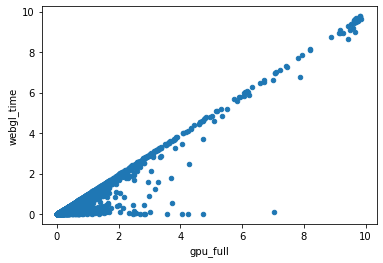

In [9]:
df_webgl[['gpu_full', 'webgl_time']].plot.scatter(x='gpu_full', y='webgl_time')

<Axes: ylabel='Frequency'>

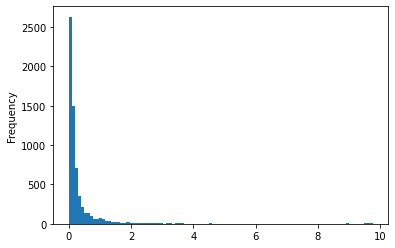

In [10]:
df_webgl.webgl_time.plot.hist(bins=100)

<Axes: ylabel='Frequency'>

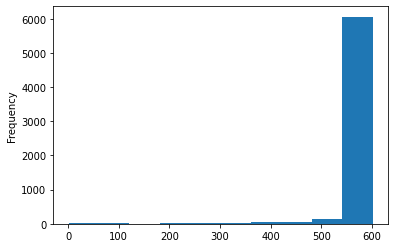

In [11]:
df_webgl.frames_count.plot.hist()

In [12]:
# df_webgl[(df_webgl.frames_count < 400) & (df_webgl.dropped_frame_duration < 2)]

In [13]:
df_webgl_array = df_webgl.iloc[:, 1:-1]

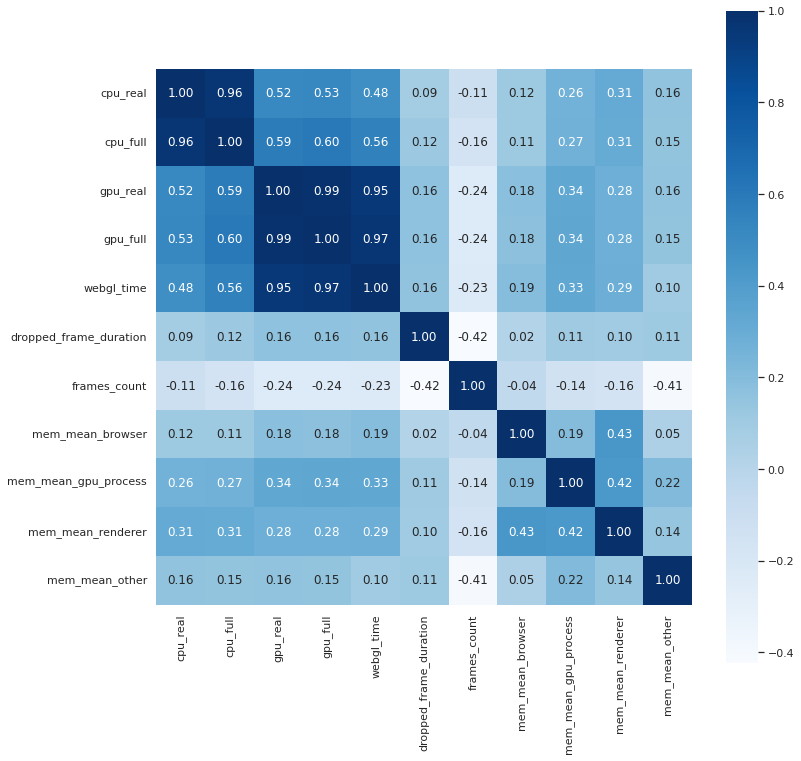

In [14]:
plt.figure(figsize=(12,12))
sns.set_theme(style="white")
corr = df_webgl_array.corr(method='pearson')
heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.2f', square=True)

In [15]:
df_webgl_array = df_webgl_array[['cpu_full', 'gpu_full', 'webgl_time', 'frames_count', 'mem_mean_gpu_process', 'mem_mean_renderer']]

In [16]:
scaler = StandardScaler()
df_webgl_array_scaled = scaler.fit_transform(df_webgl_array)
df_webgl_array_scaled

array([[-0.25717946,  0.18653662,  0.19302306,  0.02066305,  1.48626502,
         0.97574446],
       [-0.24285377,  0.27969962,  0.152356  ,  0.26817891, -0.29913139,
         0.46315584],
       [-0.17008438,  0.82381952,  0.89980463,  0.28467997, -0.03427893,
        -0.45249325],
       ...,
       [-0.18194732, -0.30537826, -0.22603013,  0.15267151, -0.12255084,
         0.12331796],
       [-0.28146144, -0.3332046 , -0.26284765,  0.25167785, -0.35980625,
        -0.56959963],
       [-0.41150009, -0.49766683, -0.39985004,  0.0371641 , -1.09503746,
         0.27582804]])

In [17]:
SSE = []
SCORE = []
RANGE = range(2, 20)
for clusters in RANGE:
    km = KMeans(n_clusters=clusters, n_init='auto', random_state=42).fit(df_webgl_array_scaled)
    SSE.append(km.inertia_)
    score = silhouette_score(df_webgl_array_scaled, km.labels_, random_state=42)
    SCORE.append(score)
SSE = np.array(SSE)
SCORE = np.array(SCORE)

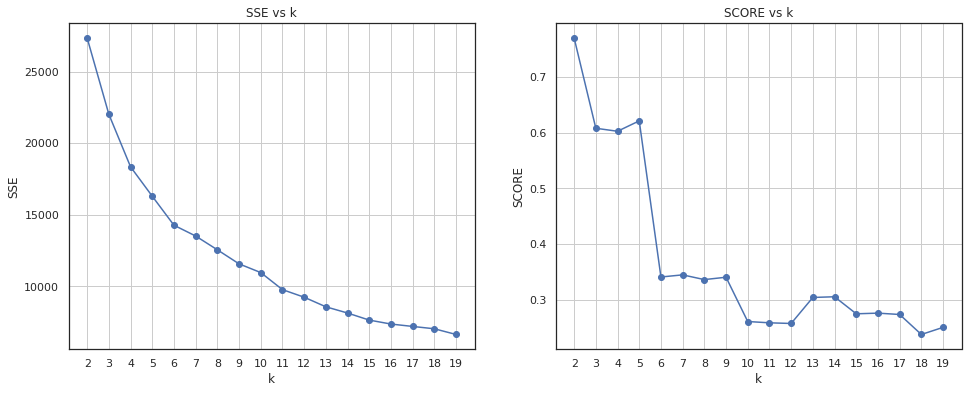

In [18]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(RANGE, SSE, 'o-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.xticks(np.arange(min(RANGE), max(RANGE)+1, 1.0))
plt.grid(True)
plt.title('SSE vs k')
plt.subplot(1, 2, 2)
plt.plot(RANGE, SCORE, 'o-')
plt.xlabel('k')
plt.ylabel('SCORE')
plt.xticks(np.arange(min(RANGE), max(RANGE)+1, 1.0))
plt.grid(True)
plt.title('SCORE vs k')
plt.show()

In [22]:
N = 5
km = KMeans(n_clusters=N, n_init='auto', random_state=42).fit(df_webgl_array_scaled)
center = km.cluster_centers_
real_center = scaler.inverse_transform(center)
# real_center_0_1 = (center - center.min(axis=0)) / (center.max(axis=0) - center.min(axis=0)) 
labels = km.labels_
num = pd.Series(labels).value_counts().sort_index().astype(str)
r = pd.concat([num, pd.DataFrame(real_center)], axis=1)
r.columns = ['num'] + list(df_webgl_array.columns)
r

,num,cpu_full,gpu_full,webgl_time,frames_count,mem_mean_gpu_process,mem_mean_renderer
0,5583,0.417670,0.286884,0.183804,587.272337,462.926747,171.103236
1,388,2.953343,1.908030,1.614628,582.422280,598.982177,266.882263
2,106,0.667766,0.457123,0.187860,219.650943,591.690832,272.056350
3,267,1.320964,0.900799,0.765728,573.468165,950.313136,682.359665
4,59,4.924441,7.979228,7.788968,416.813559,1053.161421,436.811501


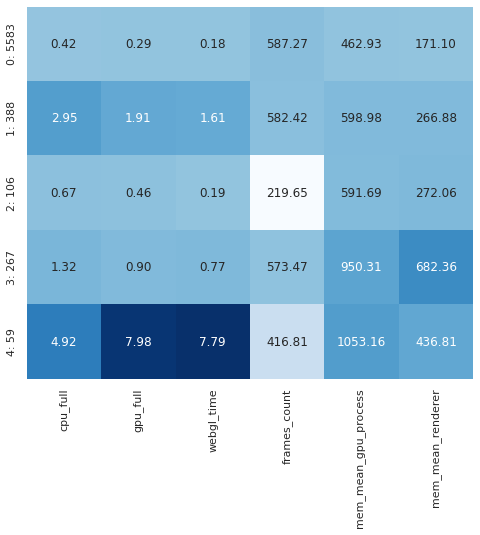

In [23]:
plt.figure(figsize=(8, 8))
sns.heatmap(center, square=True, annot=real_center, cbar=False, fmt='.2f', cmap='Blues', yticklabels=['{}: {}'.format(x,y) for x, y in zip(num.index, num.values)], xticklabels=df_webgl_array.columns) # type: ignore
plt.savefig('./output/figures/heatmap.pdf', bbox_inches='tight')

## GPU bound

In [21]:
print(df_webgl_array.loc['00359.proto.pkl'])
df_webgl_array[(labels==3)]

KeyError: '00359.proto.pkl'

In [ ]:
df_webgl_array_label = df_webgl_array.copy()
df_webgl_array_label['label'] = labels
df_webgl_array_label

In [ ]:
df_webgl_array_label.to_pickle('./output/0920-df_webgl_array_label.pkl.zstd', compression='zstd')